In [1]:
%matplotlib notebook

import os, sys, tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imsave
import pandas as pd
import napari

sys.path.append('utils')
import step01_segment_cells_and_fluorescence as funcs

from importlib import reload
reload(funcs)

<module 'step01_segment_cells_and_fluorescence' from 'W:\\people\\gritti\\linseq_zebrafish\\code_time_course\\utils\\step01_segment_cells_and_fluorescence.py'>

In [2]:
folders = [
#     os.path.join('..','HCR_time_course','hpf08','Panel1','2021-09-20_084304'), # reference for hpf08
#     os.path.join('..','HCR_time_course','hpf08','Panel1','2021-09-20_084954'), # 
#     os.path.join('..','HCR_time_course','hpf08','Panel1','2021-09-20_085804'), # 
    

#     os.path.join('..','HCR_time_course','hpf10','Panel1','2021-09-20_104647'), # reference for hpf10
#     os.path.join('..','HCR_time_course','hpf10','Panel1','2021-09-20_104949'), # 
#     os.path.join('..','HCR_time_course','hpf10','Panel1','2021-09-20_105356'), # 
    
#     os.path.join('..','HCR_time_course','hpf10','Panel2','2021-10-26_072116'),
#     os.path.join('..','HCR_time_course','hpf10','Panel2','2021-10-26_072414'),
    
#     os.path.join('..','HCR_time_course','hpf10','Panel3','2021-10-26_101501'),
#     os.path.join('..','HCR_time_course','hpf10','Panel3','2021-10-26_101721'),
#     os.path.join('..','HCR_time_course','hpf10','Panel3','2021-10-26_102004'),

#     os.path.join('..','HCR_time_course','hpf10','Panel4','2021-10-26_104907'),
#     os.path.join('..','HCR_time_course','hpf10','Panel4','2021-10-26_105128'),


#     os.path.join('..','HCR_time_course','hpf12','Panel1','2021-09-20_110602'), # reference for hpf12
#     os.path.join('..','HCR_time_course','hpf12','Panel1','2021-09-20_105648'), # 

#     os.path.join('..','HCR_time_course','hpf12','Panel2','2021-10-26_104331'), 

#     os.path.join('..','HCR_time_course','hpf12','Panel3','2021-10-26_110047'),  
#     os.path.join('..','HCR_time_course','hpf12','Panel3','2021-10-26_110714'),  

#     os.path.join('..','HCR_time_course','hpf12','Panel4','2021-10-26_111407'),  
    os.path.join('..','HCR_time_course','hpf12','Panel4','2021-10-26_111929'),  
]

cell_diameter = np.array([3.,10.,10.])
pixel_size = [2.,0.39,0.39]

gene_markers = { 
    'Panel1': ['h2bgfp','hand2','emx3','sox10','sp5l','nkx2.4b'],
    'Panel2': ['h2bgfp','pax2a','meox1','foxa2'],
    'Panel3': ['h2bgfp','ta','aldh1a2','sox17'],
    'Panel4': ['h2bgfp','sox1','prdm1','otx2'],
}
                

In [3]:
index = 0
folder = folders[index]

panel = folder.split(os.sep)[-2]

gene_markers = gene_markers[panel]

h2bFileName = os.path.join(folder, 'tifs','channels_split','h2bgfp.tif')
imgFiles = [os.path.join(folder,'tifs','channels_split',name+'.tif') for name in gene_markers]

In [4]:
imgFiles

['..\\HCR_time_course\\hpf12\\Panel4\\2021-10-26_111929\\tifs\\channels_split\\h2bgfp.tif',
 '..\\HCR_time_course\\hpf12\\Panel4\\2021-10-26_111929\\tifs\\channels_split\\sox1.tif',
 '..\\HCR_time_course\\hpf12\\Panel4\\2021-10-26_111929\\tifs\\channels_split\\prdm1.tif',
 '..\\HCR_time_course\\hpf12\\Panel4\\2021-10-26_111929\\tifs\\channels_split\\otx2.tif']

# 1. Cell segmentation

## 1.1 Load h2bGFP image

In [5]:
img = imread(h2bFileName)
print(img.shape)

(448, 2112, 2112)


In [7]:
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
2626 MiB


## 1.2 Perform segmentation (skip this if already run)

1. Normalize image to intensities of 0-1
2. Compute difference of gaussian on the image to detect blobs (includes a top-hat contrast enhancement)
3. Detect local maxima in the image
4. Fit cells on unit sphere
5. Compute local cell density
6. Filter low density cells (debris)
7. Save data as csv


In [8]:
img_norm = funcs.normalize(
                    img, 
                    percentiles=[3,99.99], 
                    percentiles_downsample=[2,2,2]
                    )
print(img_norm.shape, img_norm.dtype, np.max(img_norm), np.min(img_norm))

To float...
Percs...
Normalize...
Clip...
Done.
(448, 2112, 2112) float32 1.0 0.0


In [10]:
top_hat_radius = 1.*cell_diameter
gpu_downsample = [1,2,2]

img_DoG = funcs.runDoG(
                img_norm,
                cell_diameter = cell_diameter,
                top_hat_radius = top_hat_radius,
                gpu_downsample = gpu_downsample
                )

Push to GPU...
TopHat...
Sigma1...
Sigma2...
DoG...
Done.


In [238]:
thr_DoG = 0.01
lims = np.array([[10,10],[50,50],[50,50]])

df = funcs.runLocalMax(
                img_DoG, 
                thr_DoG = thr_DoG,
                gpu_downsample = gpu_downsample,
                lims = lims
                )

Detect local maxima...
Detect coordinates...
Filter coordinates...
Done.


<IPython.core.display.Javascript object>


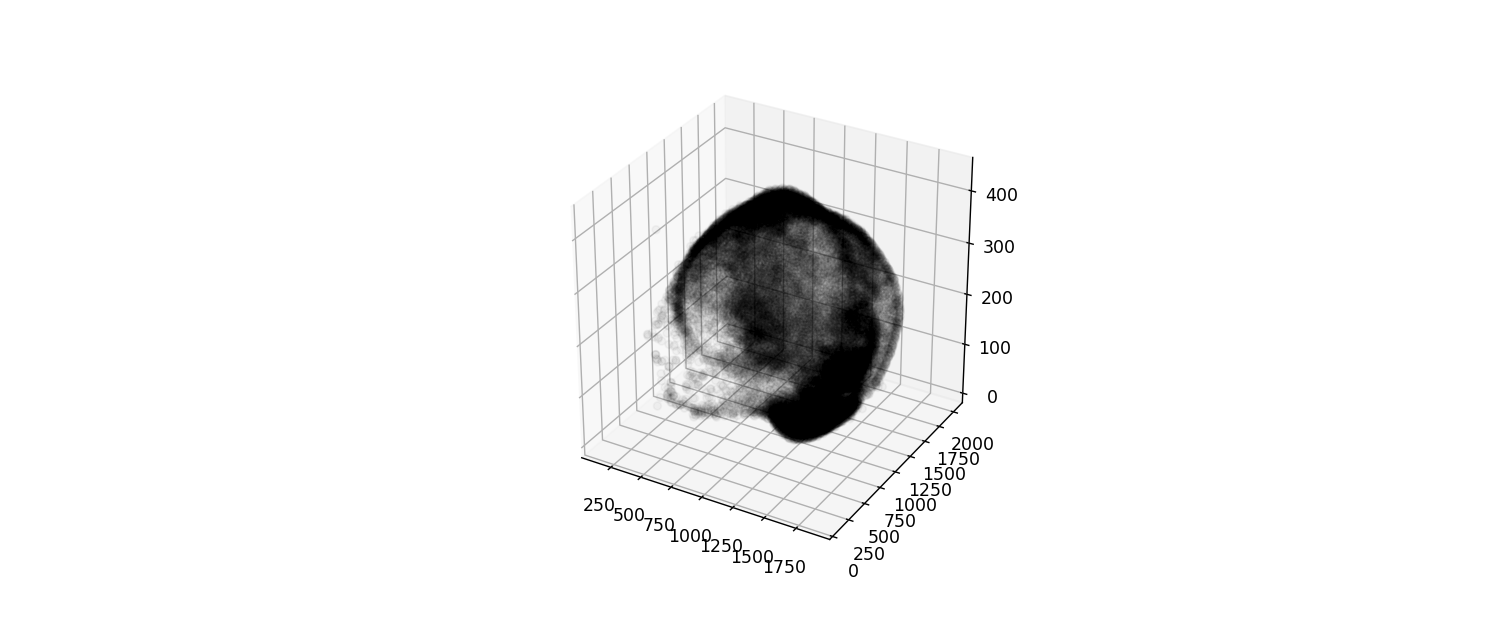

In [239]:
# plot 3D projection to check if all nuclei are more or less found
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(df.x,df.y,df.z,c='k', alpha=0.03)
ax.set_box_aspect([1,1,1])

In [240]:
df = funcs.unit_sphere(df, pixel_size=pixel_size)

utils\step01_segment_cells_and_fluorescence.py:149: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residules, rank, singval = np.linalg.lstsq(A,f)


In [241]:
# compute local density on unit sphere
num_locs_cells = len(df)
A = df[["x_unit", "y_unit", "z_unit"]].to_numpy()
density = np.zeros(num_locs_cells)
for i in tqdm.tqdm(range(num_locs_cells)):
    density[i] = np.sum(np.sqrt(np.sum((A-A[i])**2,1))<0.1)
df['density'] = density

100%|██████████████████████████████████████████████████████████████████████████| 25387/25387 [00:03<00:00, 6474.00it/s]


<IPython.core.display.Javascript object>


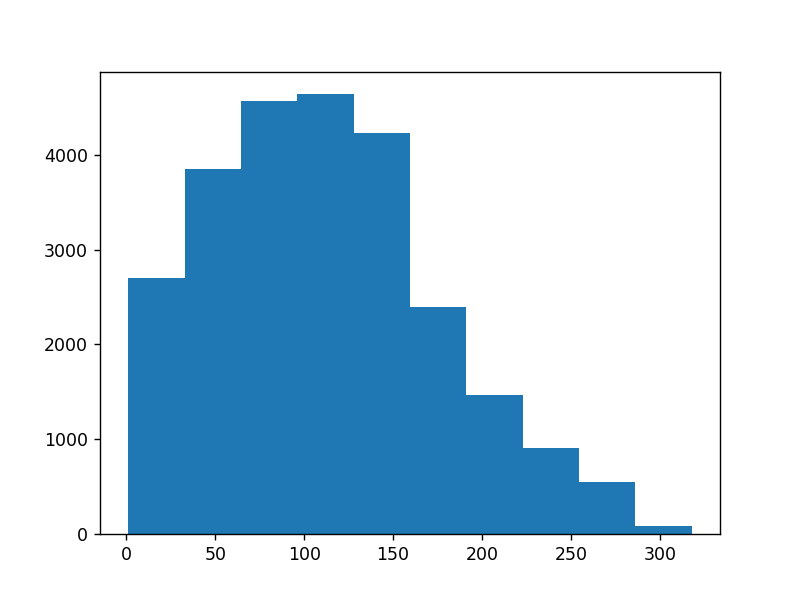

<IPython.core.display.Javascript object>


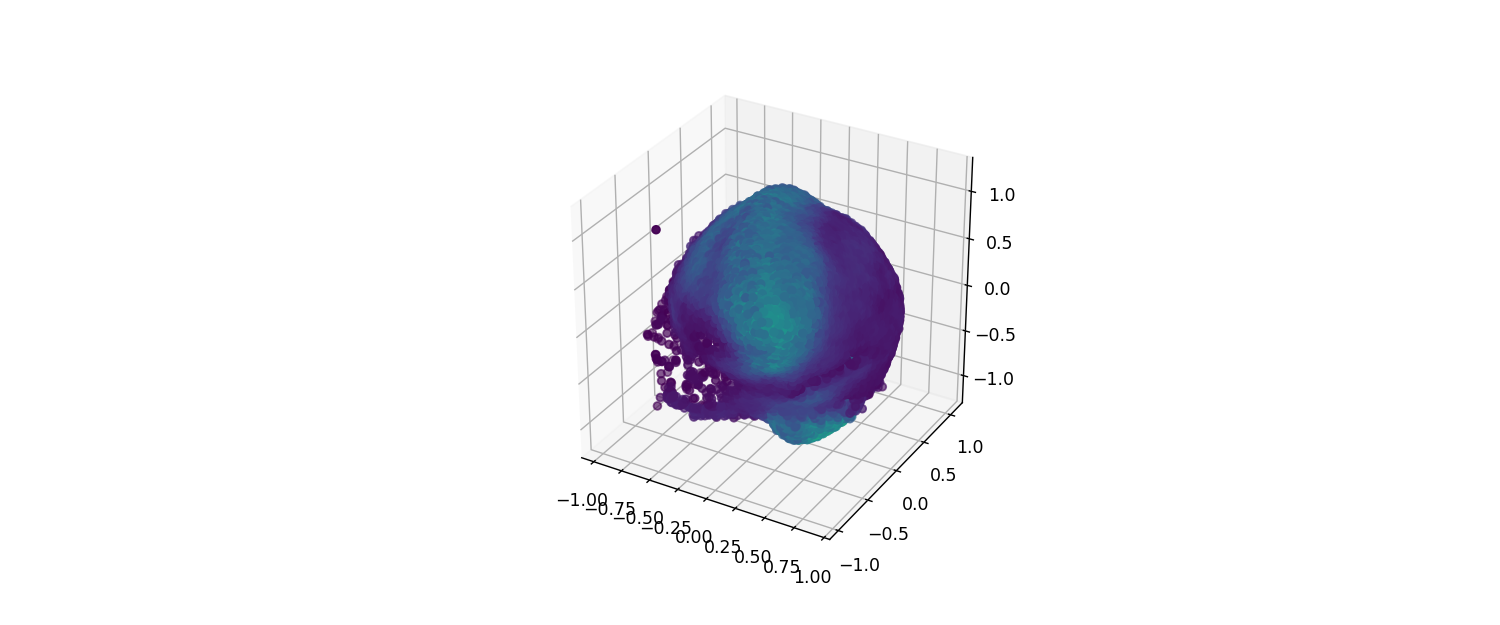

In [242]:
plt.figure()
plt.hist(df.density)

# plot 3D projection to check if all nuclei are more or less found
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(df.x_unit,df.y_unit,df.z_unit,c=df.density)
ax.set_box_aspect([1,1,1])

In [243]:
# filter low density cells assuming these are isolated debris

density_thr = 10

print(len(df))
df = df[df.density>density_thr]
print(len(df[df.density>density_thr]))

25387
25066


<IPython.core.display.Javascript object>


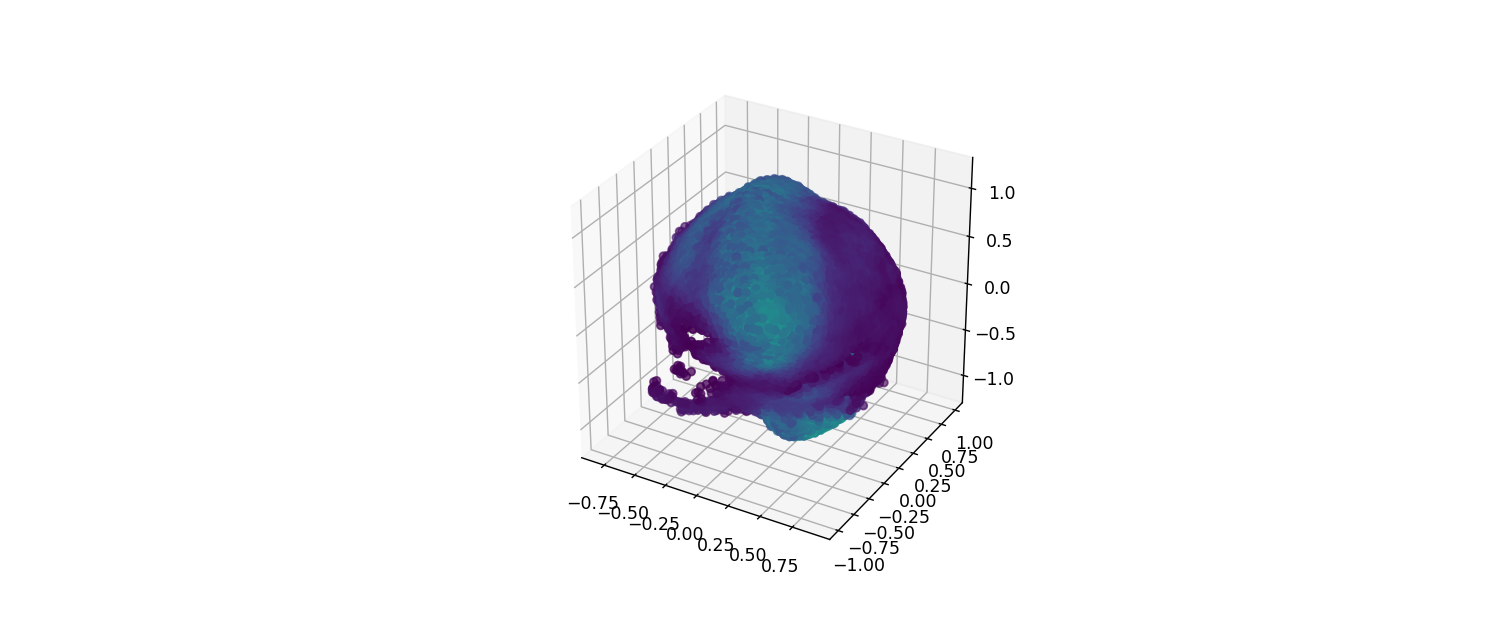

In [244]:
# plot 3D projection to check if all nuclei are more or less found
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(df.x_unit,df.y_unit,df.z_unit,c=df.density)
ax.set_box_aspect([1,1,1])

In [245]:
if not os.path.exists(os.path.join(folder,'cells_segmented')):
    os.mkdir(os.path.join(folder,'cells_segmented'))
                      
df.to_csv(os.path.join(folder,'cells_segmented','cell_pos.csv'), index=False)

## 1.3 Visualization

1. Load cell positions
2. Adjust z position for anisotropy
3. visualize in napari

In [246]:
df = pd.read_csv(os.path.join(folder,'cells_segmented','cell_pos.csv'))

In [247]:
df.head()

,z,y,x,z_unit,y_unit,x_unit,density
0,11.0,988.0,1284.0,-1.138713,-0.033230,0.264688,118.0
1,11.0,1046.0,1332.0,-1.138713,0.029087,0.316261,135.0
2,12.0,986.0,1368.0,-1.133203,-0.035379,0.354940,120.0
3,12.0,988.0,1278.0,-1.133203,-0.033230,0.258241,126.0
4,12.0,1004.0,1354.0,-1.133203,-0.016039,0.339898,135.0


<IPython.core.display.Javascript object>


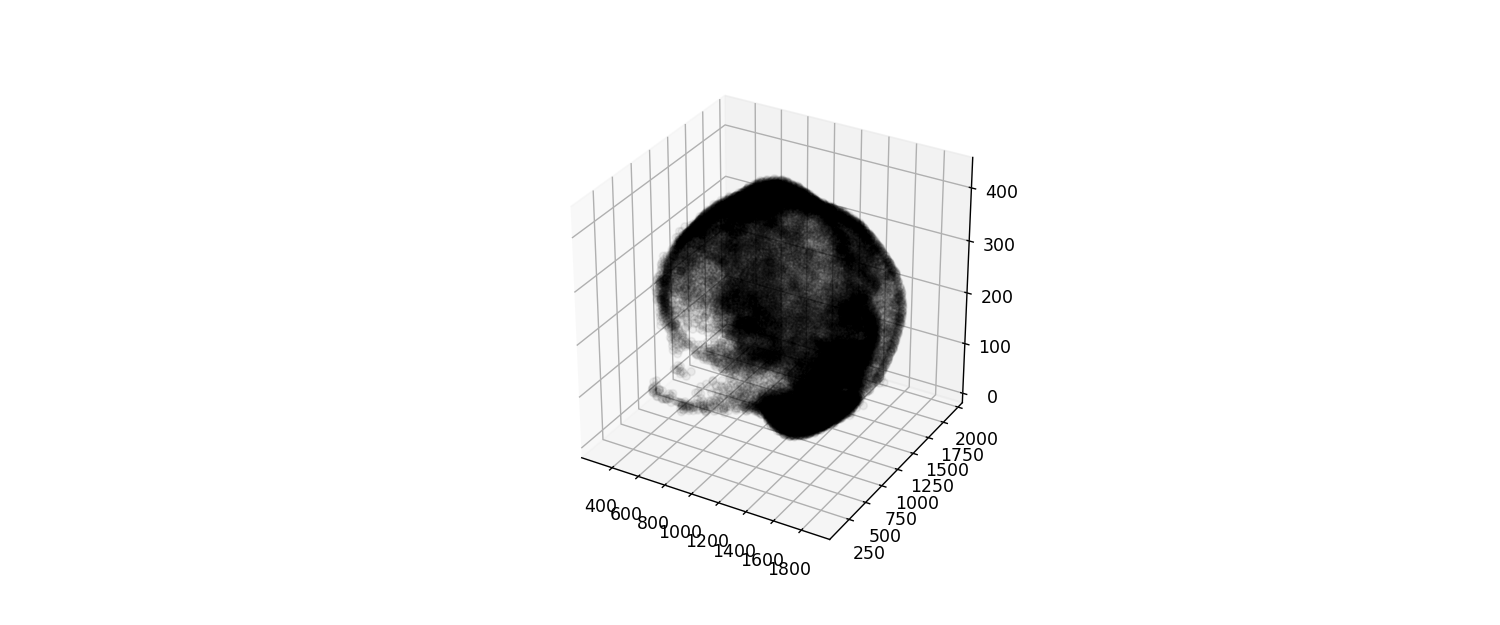

In [248]:
# plot 3D projection to check if all nuclei are more or less found
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(df.x,df.y,df.z,c='k', alpha=0.05)
ax.set_box_aspect([1,1,1])

In [249]:
anisotropy = pixel_size[0]/pixel_size[1]
df_napari = pd.DataFrame({
    'z': df.z*anisotropy,
    'y': df.y,
    'x': df.x
})

viewer = napari.Viewer()
viewer.add_image(img, scale=(anisotropy,1,1), name='zebra')
# viewer.add_image(img_DoG, scale=(1,1,1), name='zebra_gaus')
viewer.add_points(df_napari[['z','y','x']].to_numpy(), name='cells', opacity=0.3, scale=(1,1,1),face_color='red')
napari.run()

C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = canvas_size / scale


# 2. Compute fluorescence intensity in every channel

## 2.1 Load cell positions and images


In [250]:
locs_df = pd.read_csv(os.path.join(folder,'cells_segmented','cell_pos.csv'))

In [251]:
locs_df.head()

,z,y,x,z_unit,y_unit,x_unit,density
0,11.0,988.0,1284.0,-1.138713,-0.033230,0.264688,118.0
1,11.0,1046.0,1332.0,-1.138713,0.029087,0.316261,135.0
2,12.0,986.0,1368.0,-1.133203,-0.035379,0.354940,120.0
3,12.0,988.0,1278.0,-1.133203,-0.033230,0.258241,126.0
4,12.0,1004.0,1354.0,-1.133203,-0.016039,0.339898,135.0


In [252]:
imgs = [imread(f) for f in tqdm.tqdm(imgFiles)]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:32<00:00,  8.13s/it]


## 2.2 Compute fluorescence intensity in each channel and save (optional, skip these steps if already run)

In [253]:
fluos_df = funcs.compute_loc_fluo(
                            locs_df, 
                            imgs=imgs, 
                            cell_diameter=cell_diameter, 
                            ch_names=gene_markers
                            )

100%|██████████████████████████████████████████████████████████████████████████| 25066/25066 [00:13<00:00, 1809.50it/s]


In [254]:
fluos_df

,z,y,x,z_unit,y_unit,x_unit,density,h2bgfp,sox1,prdm1,otx2
0,11.0,988.0,1284.0,-1.138713,-0.033230,0.264688,118.0,412.2825,48.1850,89.4525,83.5775
1,11.0,1046.0,1332.0,-1.138713,0.029087,0.316261,135.0,537.8250,47.6675,72.1975,84.6775
2,12.0,986.0,1368.0,-1.133203,-0.035379,0.354940,120.0,671.4575,47.7200,92.3550,106.1675
3,12.0,988.0,1278.0,-1.133203,-0.033230,0.258241,126.0,489.9025,48.8400,100.5975,92.1650
4,12.0,1004.0,1354.0,-1.133203,-0.016039,0.339898,135.0,366.0650,47.9225,93.4600,97.1600
...,...,...,...,...,...,...,...,...,...,...,...
25061,424.0,972.0,980.0,1.136889,-0.050421,-0.061941,97.0,361.0300,47.2975,128.6700,72.5700
25062,424.0,1020.0,960.0,1.136889,0.001152,-0.083430,100.0,287.3500,45.1225,115.0700,81.0525
25063,424.0,1084.0,934.0,1.136889,0.069916,-0.111365,107.0,274.1175,44.7150,89.8150,66.1325
25064,425.0,980.0,946.0,1.142399,-0.041826,-0.098472,97.0,365.6000,46.1300,94.8700,65.1150


In [255]:
fluos_df.to_csv(os.path.join(folder, 'cells_segmented','cell_fluo.csv'), index=False)

## 2.3 Visualize

In [256]:
fluos_df = pd.read_csv(os.path.join(folder, 'cells_segmented','cell_fluo.csv'))
num_locs_cells = len(fluos_df)

<IPython.core.display.Javascript object>


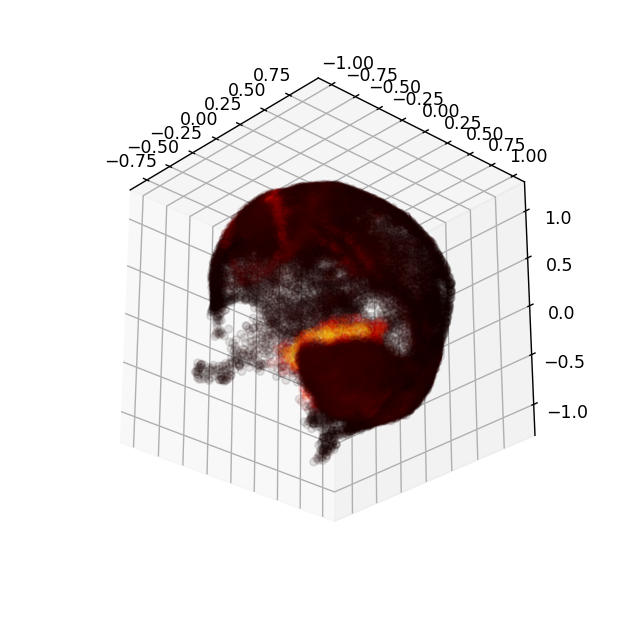

In [257]:
# plot 3D projection to check if all nuclei are more or less found
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(fluos_df.x_unit,fluos_df.y_unit,fluos_df.z_unit,c=fluos_df['prdm1'],cmap='hot',alpha=0.1)
ax.set_box_aspect([1,1,1])

<IPython.core.display.Javascript object>


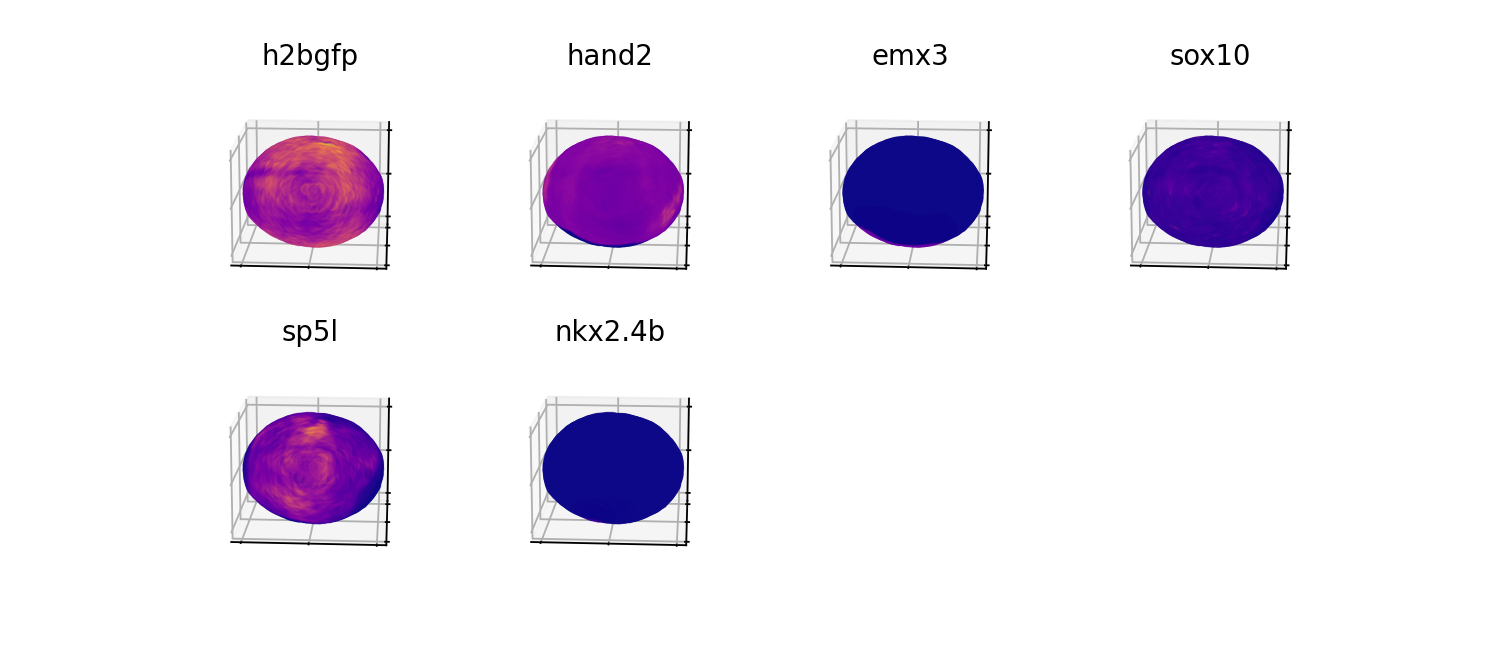

utils\step01_segment_cells_and_fluorescence.py:279: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


In [36]:
ani = funcs.rotate_animation_df(fluos_df, gene_markers, elev=15, azim_init=-60, figsize=(9,4), interval=10)

In [ ]:
# from matplotlib import animation
# writervideo = animation.FFMpegWriter(fps=6) 
# ani.save(os.path.join(folder,'cells_segmented','rotation_HCR_cells.avi'), writer=writervideo)

In [13]:
anisotropy = pixel_size[0]/pixel_size[1]
downsample = 2

df_napari = pd.DataFrame({
    'z': fluos_df.z*anisotropy,
    'y': fluos_df.y,
    'x': fluos_df.x
})

props = {i: list(fluos_df[i]) for i in fluos_df.keys()}

viewer = napari.Viewer()
colormaps = ['gray','green','cyan','magenta','yellow','red']
j=0
for img in tqdm.tqdm(imgs):
    viewer.add_image(img[:,::downsample,::downsample], scale=(anisotropy,downsample,downsample), 
                     name=gene_markers[j], colormap=colormaps[j], blending='additive',
                     contrast_limits=(0,np.max(img[:,::downsample,::downsample])/2.))
    
#     viewer.add_labels(label[:,::downsample,::downsample], scale=(anisotropy,downsample,downsample),)
#                      name='ch-%d_label'%j, blending='additive')
    j+=1
viewer.add_points(df_napari[['z','y','x']].to_numpy(), 
                  properties = props,
                  name='cells', opacity=0.3, scale=(1,1,1), face_color='z',
                 face_colormap='viridis')#, face_color='red')
napari.run()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = canvas_size / scale
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.48it/s]


In [ ]:
img = viewer.screenshot()

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(img)